# Simulating the Luria-Delbrück Experiment

### Are mutations induced or do they arise spontaneously?

This was the question faced by Salvador Lauria and Max Delbrück in 1943 when they devised their seminal fluctuation test experiment. As a modern student of biology, the answer may seem obvious, but at the time it remained a mystery. For historical context, this was 30 years after Sturtevant (1913) performed gene mapping in Drosophila, around the same time as Avery, MacLeod, and McCarty (1944) found nucleic acid instead of protein was responsible for transformation of Pneumococcus, almost 10 years before DNA was confirmed to be genetic material by Hershey and Chase (1952) and the structure of DNA was solved by Watson and Crick (1953), and more than 20 years before the neutral theory of molecular evolution was proposed by Kimura
(1968).
The inspiration for such a question came from observing the interaction between bacteria and bacteria phages (i.e. viruses that infect bacteria). A colony of bacteria growing in a flask will eventually turn the medium in the flask cloudy as the number of cells increases. It was noted that adding an equal number of bacteria phages to the flask would clear the water, as the bacteria phages lysed open the bacterial cells. However, after some time the medium in the flask would become cloudy again. This is because the bacterial became resistant to the phage by mutation. The question was then "how did these resistance mutations come about?"

<img src='graphics/Grupo_de_los_Fagos-239509034.jpeg'/> 



Lauria and Delbrück proposed two simple models for the evolution of resistance:

**1) Induced mutation: Mutations in the bacteria resulting in resistance occurred in response to the bacteria phage (i.e. mutations were induced)**

or 

**2) Spontaneous mutation: Mutations occurred spontaneously during colony growth, and bacteria carrying these mutations were already resistant prior to exposure to the phage**

***

To determine which model was correct, they devised an experiment known as the **fluctuation test**. This test proceeded as follows:

First a colony of non-resistant bacteria were grown in a flask. These bacteria were then used to innoculate media in (e.g. 11) identical test tubes. The bacteria where then allowed to grow in these test tubes until they were at a certain cell density. The test tubes were then split into two groups - for the purposes of this notebook, we will call these groups A and B. One tube was put into group A, and from this tube 10 plates, already containing bacteria phages, were innoculated with bacteria. The other 10 tubes constituted group B, and from each tube a single plate, again contaning bacteria phages, was inoculated with bacteria. The number of resistant colonies were then counted on each plate.

<img src='graphics/luria1.webp'/>

**If the first model is true, then we would expect that the variance in the number of resistant colonies per plate to be the same for parts A and B.** This is because resistance is induced at a certain rate once the bacteria are plated out, and would not depend on what had happened while the bacteria grew in the test tubes. In other words, each plate would be an independant sample, regardless of if the bacteria came from the same test tube or not - hence equal variances.

**If the second model is true, then we would expect the variance to be far greater for part B than for part A.** This is due to the fact that the resistance mutation occurs spontaneously during growth in the test tube. When plating out part A, the number of resistant colonies is representative of the frequency of resistance in the single tube, so each plate is not independant. On the other hand, in part B each tube has had an independant phase of growth, during which resistance may have spontaneously evolved early on, resulting in a high frequency of resistant colonies, or later on, resulting in few resistant colonies. Sicne the growth of bacteria is exponential, the difference in frequency will vary by orders of magnitude, resulting in high variance.

<img src='graphics/The-Luria-and-Delbrueck-experiment-In-1943-Luria-and-Delbrueck-devised-an-experiment-to-4102026779.png'/>

Prior to performing their experiment, Delbrück developed a theoretical framework from which he derived an expectation for what the variance would be under both models. When Luria performed the experiment, they found that the data matched the expectation for the second model. However, what if you were in their place? How would you develop an expectation for the variance for experiments A and B? 

Further, how could you decide on the specifics of this experiment? How many replicates would you need, or how many bacteria would you plate out? How many generations would need to be run to see an effect at the mutation rate you would expect? How would random variation in the number of cells plated out between replicates bias the results? Additionally, the experiment relies on the assumption that there is no standing genetic variance for resistance in the ancestral bacteria. How would violating this assumption effect the results?

Be happy that we are in 2024. To answer these questions and gain an intuition for (the limitations of) this experimental design, **lets simulate!!**

***

#### But how can we go about simulating something like this? 
Heres a recommendation for how to start with a simulation in general:



1. **Make your question and hypotheses as concrete as possible.**
2. **Design an experiment** that should answer your question by testing your hypotheses.
3. **Develop a good mental/visual/verbal model of steps of the experiment.** Make sure you understand the biology and the technical aspects of what you want to simulate.
4. **Break it down into subprocesses** What are the different steps involved going from initialization to final product? Describe in (painful) detail how each subprocess works - pretend like you have to describe it to an alien who has never been to Earth and knows nothing how the subprocess works. Be sure to think about potential biases.
5. **Convert those descriptions into pseudocode**, keeping in mind which data structures you will use - think about which functions you will use where, and how you will store and manage your data. What is an efficient way to code this process? Do this with a pen and paper to figure out exactly how your algorithm will work.
6. **Make the pseudocode actual code**

***

#### Lets see how we can do this for the Luria-Delbrück experiment 
For now we will just focus on the 2nd model, the one of spontaneous mutation.

The subprocesses and their descriptions are:
- **Initializing an ancestral population**
    - Create a flask with a large population of non-resistant bacteria
- **Sampling the ancestral population to create the test tubes**
    - Randomly select `n_0` cells from the ancestral flask and put these cells into new medium. Create 1 tube for part `A` and `r` tubes for part `B`. 
- **Growing the cultures**
    - In each generation, every cell produces two children cells. When the children cells are formed, there is a chance that each child will mutate some resistance. These children then become the parents for the next generation. This process repeats for `T` generations.  
- **Plating out**
    - For part `A`:
        - Randomly sample `n_sample` cells without replacement from the `A` tube for each of `r` number of plates
    - For part `B`:
        - Randomly sample `n_sample` cells without replacement from each of `r` tubes for part `B` to create one plate per tube
- **Computing the variance**
    - For each plate, count the number of resistant colonies, then calculate the variances for parts `A` and `B`





# Now lets see how we would implement this in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
T = 14 # Number of generations
n_0 = 100 # Number of cells to in a tube
mu = 1e-3 # Mutation rate
r = 50 # Number of plates (A) or tubes (B) 
n_sample = 10000 # Number of cells to plate

### Step 1. Simulation of passaging cells in a tube from a flask
Let parents be vector of $n_0$ zeros, representing $n_0$ wild type cells. For now, we (as in the original paper) assume that there are no standing genetic variation in these cells. Later you are free to relax this assumption and investigate how the presence of standing genetic variation in this step might affect the result.

In [3]:
parents = [0]*n_0

### Step 2. Growth
Let cells replicate $T$ times and mutate. First, try it with small $T$

In [4]:
T_test = 5
# Loop over T generations 
for t in range(T_test):
    # Initialise a vector children, into which we put genotype of daughter cells
    children = []
    # Loop over parent cells
    # In each iteration, `cell` is the genotype of focal cell
    for cell in parents:
        # Loop over two daughter cells
        for i in range(2):
            # Bernoulli sampling of mutation
            # Mutation is represented as addition of 1
            # The genotype of the focal daughter cell is appended 
            children.append(cell + np.random.binomial(1, mu))
    # vector parents is updated
    parents = children
# frequency distribution of cells freq(genotype == x)
Counter(parents)
## Dont forget to reset the parents array before running this again! 

Counter({0: 3195, 1: 5})

Entries greater than 1 are converted into 1 because cells whose ancestors experienced at least one muation are resistant.

In [5]:
parents = [1 if value > 0 else 0 for value in parents] 
Counter(parents)

Counter({0: 3169, 1: 31})

# Initial optimisation of steps 1 and 2
The interior nested for loops in the above code block can be substituted with a single binomial sampling of `n = 2 * length(parents)` ($= n\_0 × 2t $). We can directly update parents instead of making an intermediate vector children. And without children naming of parents wouldn’t make sense, so let us call the array genotypes. Also, things will run much faster if we switch to numpy arrays at this point.

In [6]:
genotypes = np.zeros(n_0)

for t in range(T):
    genotypes = np.concatenate((genotypes, genotypes)) + np.random.binomial(1,mu, size = genotypes.shape[0] *2)
    
genotypes = (genotypes > 0).astype(int)
Counter(genotypes)

Counter({0: 1613694, 1: 24706})

The number of resistant cells after $T$ generations is the sum of the array.

In [7]:
genotypes.sum()

24706

### Make a function `sim_tube` for steps 1 and 2 
Let’s make a function for steps 1 and 2.


In [8]:
def sim_tube(T, mu, n_0):
    genotypes = np.zeros(n_0)
    for t in range(T):
        genotypes = np.concatenate((genotypes, genotypes)) + np.random.binomial(1,mu, size = genotypes.shape[0] *2)
    return (genotypes > 0).astype(int)

Let’s simulate a tube and count the number of resistant cells

In [9]:
tube = sim_tube(T, mu, n_0)
tube.sum()

18321

Let’s see if this function actually does a right job. If we let $T = 1$, then the number of resistant cells should be around $2n_0μ$. So, when $μ$ = 0.5 and $n_0$ = 500, there should be around 500 resistant cells. Let’s simulate it 1,000 times and check the distribution of the number of resistant cells.


Text(0.5, 0, '# of Resistant Cells')

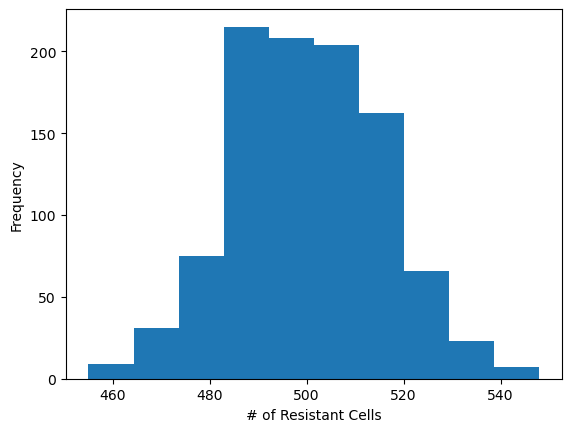

In [10]:
res = [sim_tube(1,0.5,500).sum() for i in range(1000)]
plt.hist(res)
plt.ylabel('Frequency')
plt.xlabel('# of Resistant Cells')

If we let $T = 2$, then the number of resistant cells should be around $n_0 ×2^2 ×(1−μ2)$. So, when $μ$ = 0.5 and $n_0$ = 250, there should be around 750 resistant cells. Let’s simulate it 1,000 times and check the distribution of the number of resistant cells.

Text(0.5, 0, '# of Resistant Cells')

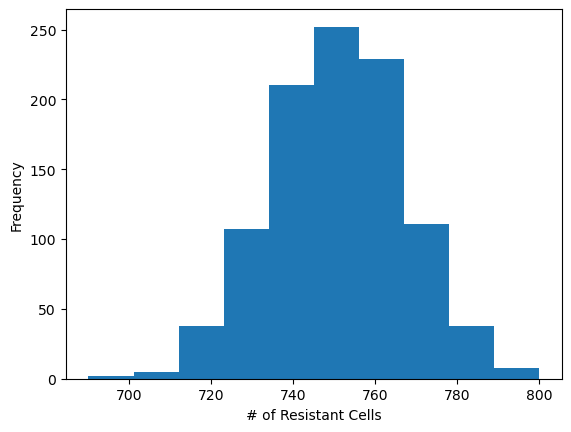

In [11]:
res = [sim_tube(2,0.5,250).sum() for i in range(1000)]
plt.hist(res)
plt.ylabel('Frequency')
plt.xlabel('# of Resistant Cells')

The simulator `sim_tube` seems to be working properly.

### Simulate resistant cells in experiment A
In experiment A, $n_0$ cells are let grow over $T$ generations (to $n_0 × 2T$ cells). The cells are plated to $r$ plates from this tube. So, we will simulate one tube before plating. The genotypes of cells are recorded in an array called `tube_a` of length $n_0 × 2T$ .

In [12]:
tube_a = sim_tube(T, mu, n_0)
tube_a[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [13]:
tube_a.shape

(1638400,)

### Simulate resistant cells in experiment B
In experiment B, there are r tubes, each of which accommodates $n_0$ cells and let them grow over $T$ generations. So, we will simulate $r$ tubes. The genotypes are recorded in an array `tubes_b` with $r$ rows and $n_0 × 2T$ columns.

In [14]:
tubes_b = np.array([sim_tube(T, mu, n_0) for i in range(r)])

### Step 3. Simulation of plating
In experiment A, we plate nsample cells from 1 tube to $r$ plates. In experiment B, we plate $n_{sample}$ cells from each of $r$ tubes to each of $r$ plates, respectively.
#### Experiment A
In experiment A, given a vector of genotypes of cells in a tube, we want an array with $r$ rows and $n_{sample}$ columns representing genotypes of cells. One can shuffle the input vector representing genotypes of cells in a tube and take the first $n_{sample}$ cells for the first plate, second $n_{sample}$ cells for the second plate, and so on.

Let’s start with plating 2 cells from 6 cells in a tube. Genotypes of the plated 2 cells can be stored in an array.

In [15]:
n_plates =  1
n_cells_plate = 2
tube_test = np.array([1, 1, 0, 0, 0, 0])
# shuffle
np.random.shuffle(tube_test)
plate_test = tube_test[:n_cells_plate]
plate_test

array([0, 0])

Then let’s try plating 2 cells from 10 cells in each of 3 plates. The output genotypes are stored in a matrix with 3 rows and 2 columns.

In [16]:
n_plates = 3
n_cells_plate = 2
tube_test = np.array([1, 1, 0, 0, 0, 0, 1, 0, 1, 0])
# shuffle
np.random.shuffle(tube_test)
# sample
plates_test = tube_test[:n_plates*n_cells_plate].reshape(n_plates,n_cells_plate)
plates_test

array([[1, 0],
       [1, 0],
       [0, 0]])

Based on the above exercise we can write a function `sim_plate`.

In [17]:
def sim_plate(tube, n_plates, n_cells_plate):
    np.random.shuffle(tube)
    plates = tube[:n_plates*n_cells_plate].reshape(n_plates,n_cells_plate)
    return plates

By running this function on our simulated `tube_a`, we can obtain `plates_a`, which is an array of genotypes.

In [18]:
plates_a = sim_plate(tube_a, r, n_sample)
plates_a.shape

(50, 10000)

### Experiment B
In experiment B, given an array with $r$ rows representing genotypes of cells in $r$ tubes, we want an array with $r$ rows and $n_{sample}$ columns representing the genotypes of the cells. Conveniently, for each tube we can use `sim_plate` function with `n_plates = 1`.

For example, for the first tube,

In [19]:
plate_b_0 = sim_plate(tubes_b[0,],1,n_sample)

We can apply this to each row of array `tubes_b` (and squeeze the output) to obtain a matrix of genotypes
`plates_b`.

In [20]:
plates_b = np.array([sim_plate(tubes_b[i,],1,n_sample) for i in range(r)]).squeeze()

In [ ]:
def col_to_num(col):
    if col == 'red':
        val = 1
    if col == 'blue':
        val = 2
    if col == 'green':
        val = 3
    if col == 'yellow':
        val = 4

In [ ]:
def col_to_num(col):
    if col == 'red':
        return = 1
    if col == 'blue':
        return = 2
    if col == 'green':
        return = 3
    if col == 'yellow':
        return = 4

### Step 4. Compute mean and variance
Both `plates_a` and `plates_b` are arrays whose rows corresponds to a replicate plate. Each entry in the array is genotype, where 0 is wild type and 1 is resistant mutant. Therefore the sum of each row is the number of resistant colonies in each plate. We can summarise the results in two values: mean and variance of the number of colonies per plate.

In [21]:
print('mean a = %s\nmean b = %s\nvar a = %s\nvar b = %s' % (plates_a.sum(axis = 1).mean(),
                                                            plates_b.sum(axis = 1).mean(),
                                                            plates_a.sum(axis = 1).var(),
                                                            plates_b.sum(axis = 1).var()))

mean a = 131.88
mean b = 135.8
var a = 128.34560000000002
var b = 1210.16


### Implementation of induced mutation model
In both experiments A and B, cells should mutate at the same rate (mutation rate) after plating. So, this is binomial sampling with rate parameter of $μ$ and size parameter of $n_{sample}$

In [22]:
def sim_ld_ind(n_plates, n_sample, mu):
    plates_a = np.random.binomial(n_sample, mu, n_plates)
    plates_b = np.random.binomial(n_sample, mu, n_plates)
    res = (plates_a.mean(),plates_b.mean(),plates_a.var(),plates_b.var())
    return res

print('mean a = %s\nmean b = %s\nvar a = %s\nvar b = %s' % sim_ld_ind(r, n_sample, mu))

mean a = 10.18
mean b = 9.74
var a = 8.2276
var b = 10.072399999999998


### Questions
Let’s address questions with our simulators. Note that our simulators are not very well optimised, and may not work well for certain situations (e.g. large $T$, large $μ$). We will further optimise the simulators in the next section, but you are already ready to play around with what you have to get an intuition of the experiment.

1) For a mutation rate of 1e-4, `T` 15 generations,`n_sample` of 10000, `r` of 50, and `n_0` of 100 cells, what is the expectation for the difference in variance of A and B for model 1?
    1) Under the induced mutation model (model 2), what mutation rate would result in the mean number of resistant cells per plate in experiments A and B being the same as in the spontaneous mutation model?
    1) In the induced mutation model with this mutation rate, what is the difference in variance between experiments A and B? How do they differ from the spontaneous mutation model?
    
2) Focus on one parameter (e.g. μ, nsample, T, r). Try to get an intuition of requirement of the parameter under which the induced and spontaneous mutation models can be distinguished.
4) Try changing the code to induce some variation in $n_{sample}$ for each replicate plate. How does this effect the results?
5) Finally, try implementing some standing genetic variation for resistance in the ancestral population from which each tube is started. Does this disrupt the experimental design?

# Further optimisations of the spontaneous mutation simulator
In the above simulators `sim_tube` and `sim_plate`, we recorded the genotypes of all cells in tubes and plates until the final step. This is very inefficient for our purpose. The information of index of the genotype vector is not used; even if someone shuffled our vector at any step of our simulation, we would not suffer. The only information we need is actually the numbers of wild type cells and resistant cells, instead of the genotype for millions of cells.

Below, we will try to improve the scripts to make it scalable and faster.

### Step 1. Simulation of passaging cells in a tube from a flask
Instead of recording genotypes of $n_0$ cells, we can have two objects to keep the number of wild type and resistant cells.

In [255]:
n_wt = n_0
n_res = 0

### Step 2. Growth
In each generation, daughter cells of resistant cells are all resistant. Some of daughter cells of wild type cells mutate to resistant, and the number of such cells follow a binomial distribution with the size parameter of $2 x n$ wild type parent cells.

In [257]:
for t in range(T):
    n_res = 2*n_res + np.random.binomial(2*n_wt, mu)
    n_wt = n_0*2**t - n_res
print('wt = %s, res = %s' % (n_wt,n_res))

wt = 797038, res = 22162


### Make a function `sim_tube_count`

In [284]:
def sim_tube_count(T, mu, n_0, n_res_init = 0):
    n_wt = n_0 - n_res_init
    n_res = n_res_init
    for t in range(T):
        n_res = 2*n_res + np.random.binomial(2*n_wt, mu)
        n_wt = n_0*2**(t + 1) - n_res
    return n_res, n_wt

Note that I added an optional argument `n_res_init`, the number of resistant cells in the initial passage, reflecting standing variation (default = 0).

Now, this `sim_tube_count` returns an integer, the number of resistant cells. By using this function, we can simulate the number of resistant cells in experiment A.

In [285]:
tube_count_a = sim_tube_count(T, mu, n_0)

By applying this function, we can simulate the number of resistant cells in experiment B. The counts are
stored in an array `tubes_count_b`.

In [286]:
tubes_count_b = np.array([sim_tube_count(T, mu, n_0) for i in range(r)])

### Step 3. Simulation of plating
Before plating, we have $n_{res}$ resistant cells and $n_{wt}$ wild type cells. In experiment A, we sample $n_{sample}$ cells without replacement sequentially over $r$ times. Each plating is equivalent to taking some balls from a box with some red and blue balls without replacement, and the number of balls with one colour follows a hypergeometric distribution.

In [287]:
def sim_plate_count(n_res, n_wt, r, n_sample):
    plates_count = np.empty(r)
    for i in range(r):
        plates_count[i] = np.random.hypergeometric(n_res,n_wt,n_sample)
        n_res = n_res - plates_count[i]
        n_wt = n_wt - (n_sample - plates_count[i])
    return plates_count

For experiment A, we use this function to obtain the number of resistant cells on $r$ plates.

In [288]:
plates_count_a = sim_plate_count(tube_count_a[0],tube_count_a[1],r,n_sample)

For experiment B, we can run this function with `n_plates = 1` $r$ times.

In [289]:
plates_count_b = np.array([sim_plate_count(tubes_count_b[i][0],tubes_count_b[i][1],1,n_sample) for i in range(r)]).squeeze()

### Step 4. Compute mean and variance

In [290]:
print('mean a = %s\nmean b = %s\nvar a = %s\nvar b = %s' % (plates_count_a.mean(),
                                                            plates_count_b.mean(),
                                                            plates_count_a.var(),
                                                            plates_count_b.var()))

mean a = 209.92
mean b = 137.4
var a = 194.11360000000002
var b = 996.0800000000002


### Make a class to do all. . .
Classes kep code neat and are useful to use for simulations that involve many functions

In [73]:
class sim_ld:
    def __init__(self,T, mu, n_0, n_sample, r, n_res_init = 0):
        self.T = T
        self.mu = mu
        self.n_0 = n_0
        self.n_sample = n_sample
        self.r = r
        self.n_res_init = n_res_init
        
    def sim_tube_count(self):
        n_wt = self.n_0 - self.n_res_init
        n_res = self.n_res_init
        for t in range(self.T):
            n_res = 2*n_res + np.random.binomial(2*n_wt, self.mu)
            n_wt = self.n_0*2**(t + 1) - n_res
        return n_res, n_wt 

    def sim_plate_count(self, n_res, n_wt, r):
        plates_count = np.empty(r)
        for i in range(r):
            try: 
                plates_count[i] = np.random.hypergeometric(n_res,n_wt,self.n_sample)
            except ValueError: # included this to catch instances when all the cells in a tube get sampled (i.e. for low T)
                print('less cells in tube than n_sample')
                break
            n_res = n_res - plates_count[i]
            n_wt = n_wt - (self.n_sample - plates_count[i])
        return plates_count

    def simulate_model1(self):
        tube_count_a = self.sim_tube_count()
        tubes_count_b = np.array([self.sim_tube_count() for i in range(self.r)])
        plates_count_a = self.sim_plate_count(tube_count_a[0],tube_count_a[1], self.r)
        plates_count_b = np.array([self.sim_plate_count(tubes_count_b[i][0],tubes_count_b[i][1],1) for i in range(self.r)]).squeeze()
        vals = (plates_count_a.mean(),
                plates_count_b.mean(),
                plates_count_a.var(),
                plates_count_b.var())
        return vals
    
    def simulate_model2(self):
        plates_a = np.random.binomial(self.n_sample, self.mu, self.r)
        plates_b = np.random.binomial(self.n_sample, self.mu, self.r)
        vals = (plates_a.mean(),
               plates_b.mean(),
               plates_a.var(),
               plates_b.var())
        return vals